<h1>Remaining Useful Life Prediction for Lithium-Ion Battery: LSTM Approach</h1>
<h2> State Of Health </h2>
<p>Generally, the remaining useful charge/discharge cycle life indicates battery’s SOH. To predict the remaining useful life (RUL)using data driven approach, the main advantage is that they do not require extensive knowledge on battery chemistry and failure mechanisms. Prognostic data are derived from measurable parameters such as voltage, current, and temperature.</p>

<p>In this project, we regard the degradation of the capacity as the indicator of the RUL.</p>

<p>Charge counting or current integration shown in equation is probably the most classical SOC calculation method:</p>
\begin{equation}
 SOC= 1- \int_ \ \frac{I*dt}{C{n}} ...........................1
\end{equation}
<i>where I is the current; Cn is the nominal capacity; t is the time.</i>
<p> <b>The capacity of battery is computed</b> by integrating discharge current over time and it is given by</p>
\begin{equation}
 Q= \int_ {t1}^{\ t2} \ {I*dt} ...............................2
\end{equation}
<i>where I is the current; Q is the capacity; and t1 and t2 are start and end time of a discharge cycle.</i>

<p>During discharge a load was placed on the battery to draw a constant current of 0.5 C (0.45 A) until the voltage decreased to 2.7 V.</p>

<p>In this project, data was collected from discharge cycles of Li-ion batteries cycled under various conditions are analyzed. The battery cycling data is sourced from a publically available repository; provided by Prognostics Center of Excellence (PCoE) at Ames Research Center, NASA</p>
<p>The data repository contains capacity, voltage, current, temperature, current load and voltage load recorded for each discharge cycle of the batteries. Except the cell capacity.</p>

In [2]:
import pandas as pd
import numpy as np
#dataset_caharge=pd.read_csv("B0005_10_charge.csv")
dataset_discharge=pd.read_csv("B0005_10_discharge.csv")
data_set=pd.read_csv("B0005_discharge1.csv")


In [3]:
#The data come from sensors are collected 
#This the original data comes from NASA for B0005
feat=['Batt_name','cycle','voltage_battery','current_battery','time']
test=dataset_discharge[feat]
print(test.head(10))
print("Number of records are: "+str(len(test)))

    Batt_name  cycle  voltage_battery  current_battery     time
0  'B0005_10'      1         4.191492        -0.004902    0.000
1  'B0005_10'      1         4.190749        -0.001478   16.781
2  'B0005_10'      1         3.974871        -2.012528   35.703
3  'B0005_10'      1         3.951717        -2.013979   53.781
4  'B0005_10'      1         3.934352        -2.011144   71.922
5  'B0005_10'      1         3.920058        -2.013007   90.094
6  'B0005_10'      1         3.907904        -2.014400  108.281
7  'B0005_10'      1         3.897036        -2.011603  126.453
8  'B0005_10'      1         3.887477        -2.018015  144.641
9  'B0005_10'      1         3.878959        -2.013135  162.844
Number of records are: 50285


<h2>Preprocessing the data</h2>

In [4]:
#These Lists used for creating new dataframe 
l1,l2,l3,l4,l5,l6,l7=[],[],[],[],[],[],[]

In [5]:
#This function read each row form the dataset and finds the current battery when the voltage drop to vol
def get_list_C_T(dataset, vol):
    cycle=1
    check=True
    current=0
    time=0.0
    sum_discharge=[]
    time_dis=[]
    for j in range(len(dataset_discharge)):
        if cycle == dataset['cycle'][j]:
            if dataset['voltage_battery'][j]>= vol and check:
                current=dataset['current_battery'][j]  
                time=dataset['time'][j]
            else:
                sum_discharge.append(current)
                time_dis.append(time)
                l1.append(cycle)
                l2.append(dataset['voltage_battery'][j])
                l3.append(dataset['time'][j])
                l4.append(dataset['temp_battery'][j])
                l5.append("B0005")
                l6.append(dataset['dateTime'][j])
                l7.append(dataset['amb_temp'][j])
                #check=False
        else:
            cycle=dataset_discharge['cycle'][j]
            current=0
    return sum_discharge,time_dis

In [6]:
# This function do Calculation for Capcaity of all discharge cycle that store in the data
def Cap_Cal(dataset,ini_cap,time_dis):
    list_Cap=[]
    Cap=[]
    Cap.append(ini_cap)
    for i in range(len(dataset)):
        if i==0:
            dt=time_dis[0]
            currents=dataset[0]
            list_Cap.append(ini_cap)
        else:
            dt=(time_dis[i] -time_dis[i-1])
            currents=(dataset[i])#+ sum_discharge[i-1])/2
            Cap_0=list_Cap[i-1]
            list_Cap.append((Cap_0-((currents*dt))/(3600)))
    return list_Cap

In [7]:
sum_discharge=[]
time_dis=[]
sum_discharge,time_dis=get_list_C_T(dataset_discharge,2.7)
print(len(sum_discharge))

168


In [8]:
dt=0.0
currents=0.0
SOC=[]
Cap=[]
res=[]
dt_ch=0.0

In [9]:
Cap.append(data_set['Capacity'][0])
Caps=data_set['Capacity'][0]
res=Cap_Cal(sum_discharge,Caps,time_dis)

In [10]:
#Create file that include the online capacity, after preprocessing in real time data, 
#and we will use this file to build LSTM model for RUL.

#create new data frame contains fields: Batt_name,cycle, dateTime, amb_temp,
#voltage_battery,temp_battery, current_battery, time, Capacity_online
new_dataset=pd.DataFrame()
new_dataset['Batt_name']=l5
new_dataset['cycle']=l1
new_dataset['dateTime']=l6
new_dataset['amb_temp']=l7
new_dataset['voltage_battery']=l2
new_dataset['temp_battery']=l4
new_dataset['current_battery']=sum_discharge
new_dataset['time']=l3
new_dataset['Capacity_online']=res

In [92]:
print(new_dataset.tail())

    Batt_name  cycle                dateTime  amb_temp  voltage_battery  \
163     B0005    164   '2008-05-26 10:44:38'        24         2.668737   
164     B0005    165   '2008-05-26 15:30:43'        24         2.696396   
165     B0005    166   '2008-05-26 20:21:04'        24         2.679483   
166     B0005    167   '2008-05-27 15:52:41'        24         2.678714   
167     B0005    168   '2008-05-27 20:45:42'        24         2.655378   

     temp_battery  current_battery      time  Capacity_online  
163     40.864674        -2.011053  2327.578         1.292325  
164     40.857545        -2.014212  2318.109         1.287053  
165     40.937025        -2.012752  2316.938         1.286416  
166     40.936092        -2.014447  2355.609         1.308020  
167     40.873909        -2.014372  2383.953         1.323923  


In [12]:
#Save the data frame into new file as frist step, after that if new discharge cycle begin for B0005 will 
#be added to this file.
new_dataset.to_csv("Capacity_onlineB5.csv")

In [13]:
data_set['Capacity_Cal']=res
#data_set.to_csv("Capacity_onlineB5.csv")

Text(0.5, 1.0, 'Discharge B0005')

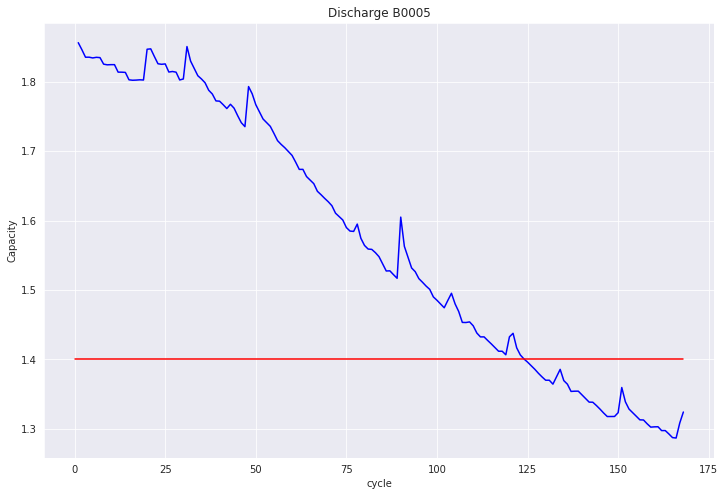

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = new_dataset.loc[(new_dataset['cycle']>=1),['cycle','Capacity_online']]
#plot_df1 = data_set.loc[(data_set['cycle']>=1),['cycle','Capacity']]

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['Capacity_online'],color='blue')
#plt.plot(plot_df1['cycle'], plot_df1['Capacity'],color='red')

#Draw threshold
plt.plot([0.,len(new_dataset)], [1.40, 1.40],color='red')
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [15]:
#This code find the difference between the capacity measured onffline 
#(by NASA) and capacity that calculated online.
test=['cycle','Capacity','Capacity_Cal']
new_data1=data_set[test]
difer=[]
for i in range(len(new_data1)):
    difer.append(new_data1['Capacity'][i]-new_data1['Capacity_Cal'][i])
new_data1['differ']=difer
print(new_data1.head())
sum_error=0
for i in range(len(new_data1)):
    sum_error=sum_error+ new_data1['differ'][i]
print("The avg of Error is "+str(sum_error/len(new_data1)))

   cycle  Capacity  Capacity_Cal    differ
0      1  1.856487      1.856487  0.000000
1      2  1.846327      1.846393 -0.000066
2      3  1.835349      1.835524 -0.000175
3      4  1.835263      1.835577 -0.000314
4      5  1.834646      1.834502  0.000144
The avg of Error is 0.0005989038535388082


/home/khaled/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
#Caculate SOH
test=['cycle','Capacity','Capacity_Cal']
new_data=data_set[test]
SOH=[]
init=new_data['Capacity_Cal'][0]
for i in range(len(new_data)):
    SOH.append(new_data['Capacity_Cal'][i]/2.0)
    #print(str(i) + "  "+str(new_data['Capacity_Cal'][i]/2.0))
new_data['SOH']=SOH


/home/khaled/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5, 1.0, 'Discharge B0005')

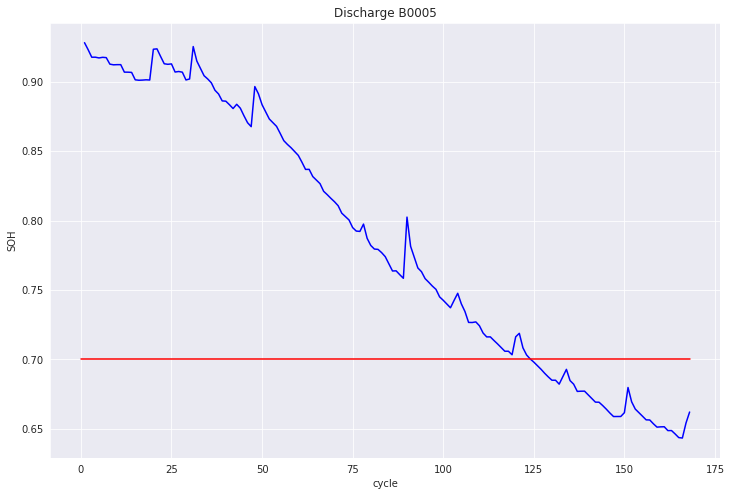

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = new_data.loc[(new_data['cycle']>=1),['cycle','SOH']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['SOH'],color='blue')
#plt.plot(plot_df1['cycle'], plot_df1['Capacity'],color='red')

#Draw threshold
plt.plot([0.,len(new_data)], [0.70, 0.70],color='red')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [18]:
print(new_data.head())

   cycle  Capacity  Capacity_Cal       SOH
0      1  1.856487      1.856487  0.928244
1      2  1.846327      1.846393  0.923197
2      3  1.835349      1.835524  0.917762
3      4  1.835263      1.835577  0.917788
4      5  1.834646      1.834502  0.917251


In [75]:
df = pd.read_csv('Coll_Cap_B56718.csv')

Text(0.5, 1.0, 'Discharge B0005')

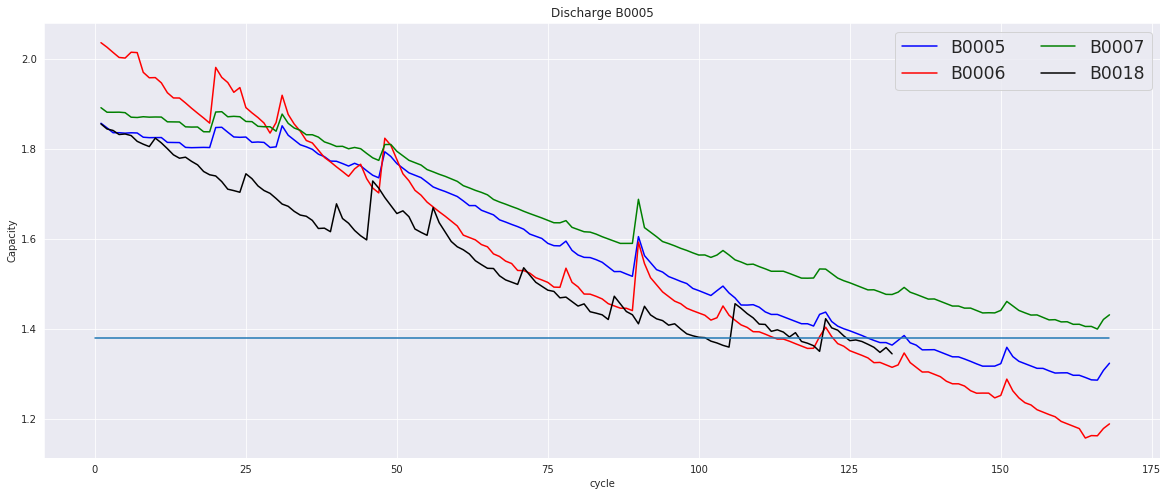

In [91]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = df.loc[(df['cycle']>=1)&(df['Batt_name']==1),['cycle','Online_Capacity']]
plot_df1=df.loc[(df['cycle']>=1)&(df['Batt_name']==2),['cycle','Online_Capacity']]
plot_df2=df.loc[(df['cycle']>=1)&(df['Batt_name']==3),['cycle','Online_Capacity']]
plot_df3=df.loc[(df['cycle']>=1)&(df['Batt_name']==4),['cycle','Online_Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df['cycle'], plot_df['Online_Capacity'], label="B0005", color='blue')
plt.plot(plot_df1['cycle'], plot_df1['Online_Capacity'], label="B0006", color='red')
plt.plot(plot_df2['cycle'], plot_df2['Online_Capacity'], label="B0007", color='green')
plt.plot(plot_df3['cycle'], plot_df3['Online_Capacity'], label="B0018", color='black')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38])
plt.ylabel('Capacity')
# make x-axis ticks legible
plt.legend(loc='upper right', ncol=2,fontsize='xx-large')
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')